# Optimal Route

How can you know the fastest way to get from point A to point B? Well you need to know the distance between points, of course. But what if there are multiple non-linear ways to get there? What then?

This is where experience comes in. This experience is usually only gained once you:
1) reach the end of the trip and
2) have tried multiple trip paths to know the best one.

Fortunately, machines can learn the same way! We can provide an agent its environment, tell it where to start, where to end, and where to avoid. The agent will be rewarded only when it reaches its destination. Just like humans don't like waiting in traffic or taking all day to get somewhere, we can discount its final reward by diminishing its reward over time spent getting to its destination. This will "motivate" the agent to pick routes that took as little time as possible. 

I'll set up a deterministic discrete 4 x 3 environment where there are states and actions that occur in turns. This environment will have a negative reward state and a positive reward state, as well as an untoucable / roadblock area. Most of the time (except TD learning) the agent will make a policy of moves it should take only once it reaches a terminal state, which in this case is 1 or -1. Once that maximum reward is found it will look back on which moves it took to get to that point, which we call dynamic programming. 

With these rules in mind, what would prevent it from just wandering for a long period of time before transitioning to the +1 state? This is where the discounted environment comes in.

If we can discount that reward of 1 with -0.1 each time the agent makes a transition between states, then it will want to make as few moves as possible to to maximize its reward. Once it does get to the end, it looks back at the moves it took to get there and calculates the value. So if it took 10 moves, the reward would be 0 (10 moves * -0.1 per move + reward [+1]). Then it tries again. If the second round only took 6 moves, then the reward is 0.4 which is greater. The process repeats until the gain in reward no longer improves. We can also add a hyperparameter called gamma. This is a reward multiplier that can either grow your reward or shink your reward over time depending if its greater than or less than 1. Ours will be set to 0.9

After setting up the environment and agent, I will walk us through a history of thinking in reinforcement learning that follows somewhat of an evolution of the subject. We will start with **Policy and Value Evaluation and Iteration**, which looks at all possible states and values, but can become computationally expensive. We will then evolve to less a expensive method called **Monte Carlo Learning**, which updates the policy based of episodes that sample from the state space. Then we will end with state-to-state updates with like **Temporal Difference Learning** and an efficient method called **Q-Learning**.

** Disclaimer: Most of this code was taken from Udacity's reinforcement learning course which I have slightly modified for teaching purposes **

In [1]:
# Note: you may need to update your version of future
# sudo pip install -U future
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt 

class Grid: # Environment
    def __init__(self, width, height, start):
        self.width = width
        self.height = height
        self.i = start[0]
        self.j = start[1]
    
    # This function makes rewards and actions per state into class attributes but is added to the class once they are specified
    def set(self, rewards, actions):
        # rewards should be a dict of: (i, j): r (row, col): reward
        # actions should be a dict of: (i, j): A (row, col): list of possible actions
        self.rewards = rewards
        self.actions = actions
    
    # Takes a tuple of a state and assigns each x and y index to i and j
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
    
    # Returns tuple of current state
    def current_state(self):
        return (self.i, self.j)
    
    # Checks if agent has reached a terminal state
    def is_terminal(self, s):
        return s not in self.actions
    
    # How the agent interacts with the environment
    def move(self, action):
        # Check if legal move first
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
        # Return a reward from that state if any. If none, return 0
        return self.rewards.get((self.i, self.j), 0)
    
    # Used to backtrack as the optimal policy is calculated
    def undo_move(self, action):
        # These are the opposite of what U/D/L/R should normally do
        if action == 'U':
            self.i += 1
        elif action == 'D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1
        # Raise an exception if we arrive somewhere we shouldn't be
        assert(self.current_state() in self.all_states())
    
    # Returns true if game is over, else false
    def game_over(self):
        # true if we are in a state where no actions are possible
        return (self.i, self.j) not in self.actions
    
    # Simple way to get all states. ***Possibly buggy***
    def all_states(self):
        # Either a position that has possible next actions or a position that yields a reward
        return set(self.actions.keys()) | set(self.rewards.keys())

# Define a grid that describes the reward for arriving at each state and possible actions at each state
def standard_grid():
    g = Grid(3, 4, (2, 0))
    # 'rewards' disctionary has states as keys and consequnces as values
    rewards = {(0, 3): 1, (1, 3): -1}
    # 'actions' dictionary has states as keys and possible actions as values
    actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
    }
    g.set(rewards, actions)
    return g

# Same as above but has a step cost / penalty for moving
def negative_grid(step_cost=-0.1):
    g = standard_grid()
    g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
    })
    return g

# Prints a representation of the map with the values given 
def print_values(V, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") # -ve sign takes up an extra space
        print("")

# Prints out map with policy actions given each state
def print_policy(P, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

In [2]:
# Test out the grid
g = Grid(width = 3, height = 4, start = (2,0))
grid = standard_grid()

# Check out all the states, the actions per state, and the possible rewards for the standard grid
print('All States:', '\n', grid.all_states(), '\n')
print('All Actions:', '\n', grid.actions, '\n')
print('All Standard-grid Rewards:', '\n', grid.rewards, '\n')

# All is the same in the negative grid except the 'rewards' for all the neutral states are now -0.1
neg_grid = negative_grid()
print('All Negative-grid Rewards:', '\n',neg_grid.rewards)

All States: 
 {(0, 1), (1, 2), (0, 0), (1, 3), (2, 1), (2, 0), (2, 3), (2, 2), (1, 0), (0, 2), (0, 3)} 

All Actions: 
 {(0, 1): ('L', 'R'), (1, 2): ('U', 'D', 'R'), (0, 0): ('D', 'R'), (2, 3): ('L', 'U'), (2, 0): ('U', 'R'), (1, 0): ('U', 'D'), (2, 2): ('L', 'R', 'U'), (0, 2): ('L', 'D', 'R'), (2, 1): ('L', 'R')} 

All Standard-grid Rewards: 
 {(0, 3): 1, (1, 3): -1} 

All Negative-grid Rewards: 
 {(0, 1): -0.1, (1, 2): -0.1, (1, 3): -1, (2, 1): -0.1, (0, 2): -0.1, (2, 0): -0.1, (0, 0): -0.1, (2, 3): -0.1, (2, 2): -0.1, (0, 3): 1, (1, 0): -0.1}


### Iterative Policy Evaluation

This method allows an agent to search all possible states and actions by first randomly allowing the agent to choose a policy, evaluate that policy and then update that policy until a certain criterion is met. In this case the criterion will be a threshold of value change. We take the maximum of the difference in value across all states from one epoch/iteration to the next. If the max value of all the states' changes in value is below 0.001 then we will consider the algorithm to have converged.

NOTE:
There are 2 sources of randomness:

1) p(action|state) - deciding what action to take given the state

2) p(next_state', reward|state, action) - the next state and reward given your action-state pair

Since the negative grid is being used it gives you a reward of -0.1 for transitioning between every non-terminal state. This grid will be used throughout this walkthrough. This will encourage finding a shorter path to the goal.

In [3]:
# Here are some of the hyperparameters we can tweak to get different outputs
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

if __name__ == '__main__':
    grid = negative_grid()

    print('Rewards:')
    print_values(grid.rewards, grid)

    # We'll randomly choose an action and update as we learn
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    print('\n', 'Initial policy:')
    print_policy(policy, grid)

    # Initialize V(s)
    V = {}
    states = grid.all_states()
    for s in states:
        # V[s] = 0
        if s in grid.actions:
            V[s] = np.random.random()
        else:
            # Terminal state
            V[s] = 0
            
    # Record biggest change within state for each iteration
    biggest_change_list = []
    
    # Repeat until convergence - will break out when policy does not change
    while True:
        # Policy evaluation step
        while True:
            biggest_change = 0
            for s in states:
                old_v = V[s]
                # V(s) only has value if it's not a terminal state
                if s in policy:
                    a = policy[s]
                    grid.set_state(s)
                    r = grid.move(a)
                    V[s] = r + GAMMA * V[grid.current_state()]
                    biggest_change = max(biggest_change, np.abs(old_v - V[s]))
            biggest_change_list.append(biggest_change)
            if biggest_change < SMALL_ENOUGH:
                break
    
        # Policy improvement step
        is_policy_converged = True
        for s in states:
            if s in policy:
                old_a = policy[s]
                new_a = None
                best_value = float('-inf')
                # loop through all possible actions to find the best current action
                for a in ALL_POSSIBLE_ACTIONS:
                    grid.set_state(s)
                    r = grid.move(a)
                    v = r + GAMMA * V[grid.current_state()]
                    if v > best_value:
                        best_value = v
                        new_a = a
                policy[s] = new_a
                if new_a != old_a:
                    is_policy_converged = False
        if is_policy_converged:
            break

    print('\n', 'Values:')
    print_values(V, grid)
    print('\n', 'Policy:')
    print_policy(policy, grid)

Rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|

 Initial policy:
---------------------------
  L  |  D  |  R  |     |
---------------------------
  R  |     |  L  |     |
---------------------------
  D  |  D  |  U  |  L  |

 Values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|

 Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


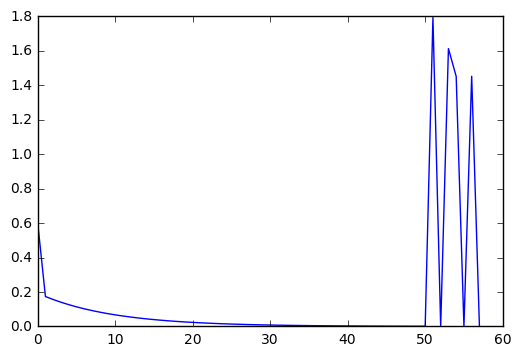

In [4]:
# Plot biggest change
plt.plot(biggest_change_list)
plt.show()

The learning occurred with small changes in maximum deltas over iterations until about later epochs where a large change in at least one of the states occurred. Due to the algorithm's properties, we are almost certain that this was an improvement from around -1 to around 1, thus giving a difference of almost 2. Then for each iteration the adjascent states likely changed as a result, resulting in 2 more spikes of learning until convergence. 

If you compare the initial random policy to the final policy, you can see how much it improved through this process. Comparitively this process took a while to do so converge. Fortunately there are better ways.

 ### Value Iteration
 
As mentioned, iterating between policies to evaluate and then update them is not the only way to teach an agent to find its way from point A to point B. Instead we can iterate over the values themselves to find the optimal values and THEN update the policy to give those values at the end. If we try to change the policy after every litte shift in value it will usually take longer. This also requires a bit less code (notice the outer 'while' loop is now removed), which makes this method a win-win for both agent and programmer.

In [5]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

if __name__ == '__main__':
    # this grid gives you a reward of -0.1 for every non-terminal state
    # we want to see if this will encourage finding a shorter path to the goal
    grid = negative_grid()
    # state -> action
    # we'll randomly choose an action and update as we learn
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    print('\n', 'Initial policy:')
    print_policy(policy, grid)
    print()

    # Initialize V(s)
    V = {}
    states = grid.all_states()
    for s in states:
        # V[s] = 0
        if s in grid.actions:
            V[s] = np.random.random()
        else:
            # Terminal state
            V[s] = 0

    # Repeat until convergence
    # V[s] = max[a]{ sum[s',r] { p(s',r|s,a)[r + GAMMA*V[s']] } }
    count = 0
    while True:
        count += 1
        biggest_change = 0
        for s in states:
            old_v = V[s]
            # V(s) only has value if it's not a terminal state
            if s in policy:
                new_v = float('-inf')
                for a in ALL_POSSIBLE_ACTIONS:
                    grid.set_state(s)
                    r = grid.move(a)
                    v = r + GAMMA * V[grid.current_state()]
                    if v > new_v:
                        new_v = v
                V[s] = new_v
                biggest_change = max(biggest_change, np.abs(old_v - V[s]))

        print('Biggest Value Change per Iteration', '\n', count,biggest_change)

        if biggest_change < SMALL_ENOUGH:
            break

    # find a policy that leads to optimal value function
    for s in policy.keys():
        best_a = None
        best_value = float('-inf')
        # loop through all possible actions to find the best current action
        for a in ALL_POSSIBLE_ACTIONS:
            grid.set_state(s)
            r = grid.move(a)
            v = r + GAMMA * V[grid.current_state()]
            if v > best_value:
                best_value = v
                best_a = a
        policy[s] = best_a

    # Our goal here is to verify that we get the same answer as with policy iteration
    print('\n', 'Values:')
    print_values(V, grid)
    print('\n', 'Policy:')
    print_policy(policy, grid)


 Initial policy:
---------------------------
  R  |  D  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  D  |  R  |  L  |

Biggest Value Change per Iteration 
 1 0.5923902660856444
Biggest Value Change per Iteration 
 2 0.15749326716258094
Biggest Value Change per Iteration 
 3 0.10523940446322833
Biggest Value Change per Iteration 
 4 0

 Values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|

 Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


This method only took 4 iterations! In a way this method is much more of a "think before you act" method than policy iteration is. However there are many environments that will not be able to iterated over every state and action to get a value. Some environments have too many states to hold in memory. In these situations we must code in a way closer to how humans think. 

### Monte Carlo Method

We will still use the same environment for simplicity's sake, but instead of iterating through every state and action, we will pick random actions at each state until a terminal state is met. We will then calculate the value for each state-action pair in that path and repeat the process, appending a value to each state-action the agent is a part of. The list of values each state accumulates is then averaged to get an estimate for that states value, given an action. This process continues until we say so, or more accurately, until we think an optimal policy has been found. In large environments however, we would not be sure this was an optimal policy globally, but would have a level of confidence based off the end result.

0 Episodes
1000 Episodes
2000 Episodes
3000 Episodes
4000 Episodes


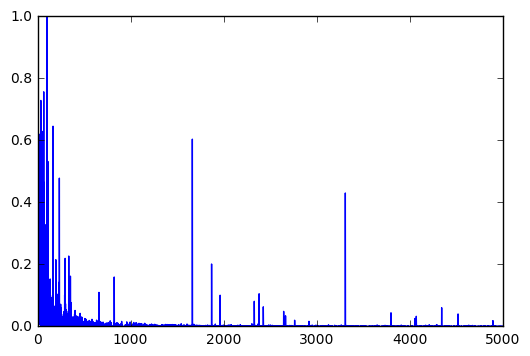


 Final values:
---------------------------
 0.58| 0.77| 1.00| 0.00|
---------------------------
 0.41| 0.00| 0.77| 0.00|
---------------------------
 0.25| 0.09| 0.00|-0.39|

 Final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  L  |  L  |


In [6]:
# NOTE: find optimal policy and value function using on-policy first-visit MC
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# Returns the argmax (key) and max (value) from a dictionary
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

def random_action(a, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

# In this version we will NOT use "exploring starts" method. Instead we will explore using an epsilon-soft policy
# Returns a list of states and corresponding returns
def play_game(grid, policy):
    s = (2, 0)
    grid.set_state(s)
    a = random_action(policy[s])
    # Each triple is s(t), a(t), r(t) but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [(s, a, 0)]
    while True:
        r = grid.move(a)
        s = grid.current_state()
        if grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_action(policy[s]) # The next state is stochastic
            states_actions_rewards.append((s, a, r))

    # Calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        # We should ignore the first state we encounter and the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    states_actions_returns.reverse() # We want it to be in order of state visited
    return states_actions_returns


if __name__ == '__main__':
    grid = negative_grid(step_cost=-0.1)
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    Q = {}
    returns = {} # Dictionary of state -> list of returns we've received
    states = grid.all_states()
    for s in states:
        if s in grid.actions:
            Q[s] = {}
            for a in ALL_POSSIBLE_ACTIONS:
                Q[s][a] = 0
                returns[(s,a)] = []
        else:
            # Terminal state or state we can't otherwise get to
            pass

    # Repeat until convergence
    deltas = []
    for t in range(5000):
        if t % 1000 == 0:
            print(t, 'Episodes')

        biggest_change = 0
        states_actions_returns = play_game(grid, policy)

        # Calculate Q(s,a)
        seen_state_action_pairs = set()
        for s, a, G in states_actions_returns:
            # Check if we have already seen s. Called "first-visit" MC policy evaluation
            sa = (s, a)
            if sa not in seen_state_action_pairs:
                old_q = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
                seen_state_action_pairs.add(sa)
        deltas.append(biggest_change)

        # Calculate new policy
        for s in policy.keys():
            a, _ = max_dict(Q[s])
            policy[s] = a

    plt.plot(deltas)
    plt.show()

    # Find the optimal state-value function
    V = {}
    for s in policy.keys():
        V[s] = max_dict(Q[s])[1]

    print('\n', 'Final values:')
    print_values(V, grid)
    print('\n', 'Final policy:')
    print_policy(policy, grid)

Though we have not iterated through each state and its actions to know its value for sure, after 5000 rounds of playing the game we were able to estimate each state's value. With these values we can update the policy to get an estimated policy. In larger environments this method is much more tractable and allows for more accurate estimates of an optimal policy as it iterates to a terminal state / threshold of rewards.

Do notice the list of deltas, which is similar to the plot under Iterative Policy Evaluation. It shows the max difference in values as policies were changed. Roughly speaking, these spikes in differences are mostly (if not completely) differences that maximize state-action values, making them moments where the algorithm learned. You can see the magnitude of learning in the max state-action value difference per episode. In humans, this is perhaps known as an 'a-ha' moment. Mathematically it is different, but the general idea draws similarities.

### Temporal Difference Learning

With Monte Carlo methods "learning" can only occur at the end of each episode. Temporal difference learning allows a model to learn while still within an episode. From state to state the value is estimated which I will display below using a fixed policy.

In [7]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# NOTE: this is only policy evaluation, not optimization

# Returns a list of states and corresponding rewards (not returns as in MC)
def play_game(grid, policy):
    # Start at the designated start state
    s = (2, 0)
    grid.set_state(s)
    states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
    while not grid.game_over():
        a = policy[s]
        a = random_action(a)
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s, r))
    return states_and_rewards


if __name__ == '__main__':
    grid = negative_grid()

    # state -> action
    policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'R',
    (2, 2): 'U',
    (2, 3): 'L',
    }

    V = {}
    V_list_first = []
    V_list_last = []
    states = grid.all_states()
    for s in states:
        V[s] = 0

    # Repeat until convergence
    for it in range(1000):
        # generate an episode using pi
        states_and_rewards = play_game(grid, policy)
        # the first (s, r) tuple is the state we start in and 0
        # (since we don't get a reward) for simply starting the game
        # the last (s, r) tuple is the terminal state and the final reward
        # the value for the terminal state is by definition 0, so we don't
        # care about updating it.
        for t in range(len(states_and_rewards) - 1):
            s, _ = states_and_rewards[t]
            s2, r = states_and_rewards[t+1]
            # We will update V(s) as we experience the episode
            V[s] = V[s] + ALPHA*(r + GAMMA*V[s2] - V[s])
            if it == 1:
                V_list_first.append(V[s])
            if it == 999:
                V_list_last.append(V[s])
                
    print('Second Episode Values:', '\n', V_list_first, '\n')
    print('Last Episode Values:', '\n', V_list_last, '\n')
    print("Policy:")
    print_policy(policy, grid)


Second Episode Values: 
 [-0.0199, -0.0199, -0.0199, -0.020791000000000004, -0.029701000000000005, -0.03058309, -0.03948337810000001, -0.041078285029, -0.04740623029000001, -0.019711900000000004, 0.19] 

Last Episode Values: 
 [0.2429407893009413, 0.41189915071709304, 0.5707748744055352, 0.7684182047350576, 0.9910700220136391] 

Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


I am displaying the learning that took place in the second and last values. I'm using the second episode because it is going off the reward at the end of the first episode. We can also see the values of the last episode to see if there was improvement after many episodes. Within each episode the current value is calculated using each following value in a chain of value evaluation which makes for more dynamic environment searching.

### Q-Learning

This is perhaps the most widly used and successful method of reinforcement learning. It has a similar feel to Monte Carlo learning in that it does not have to explore the entire environment, however it's different in that it doesnt average returns of explored states. In Q-learning an agent is able to explore state-action pairs without actually saving them / changing the policy, making this an off-policy reinforcement method. The agent will only update its state-action value (known as Q) if it exceeds the current state-action value. This allows for very quick convergence in environments that cannot be fully explored. It also allows for better management of memory since less optimal exploration is not saved.

One other thing that makes Q-learning different is the hyperparameter alpha. This is a learning rate that determines what proportion of the max value update should be used to add to the current value, which allows the algorithm to take larger or smaller steps toward the direction it's learning. The method coded below takes it one step further and decreases this learning rate by 0.005 each iteration so that the agent takes smaller and smaller steps toward convergence.

Let's see how it learns.

it: 0


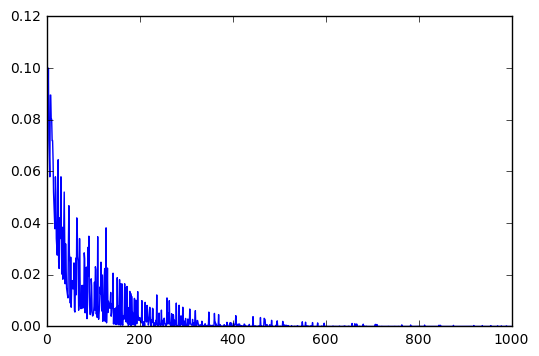

In [8]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

if __name__ == '__main__':
    grid = negative_grid()

    # No policy initialization, we will derive our policy from most recent Q. Initialize Q(s,a)
    Q = {}
    states = grid.all_states()
    for s in states:
        Q[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0

    # Let's also keep track of how many times Q[s] has been updated
    update_counts = {}
    update_counts_sa = {}
    for s in states:
        update_counts_sa[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            update_counts_sa[s][a] = 1.0

    t = 1.0
    deltas = []
    for it in range(1000):
        if it % 100 == 0:
            t += 1e-2
        if it % 2000 == 0:
            print("it:", it)
        # Instead of 'generating' an epsiode, we will PLAY an episode within this loop
        s = (2, 0) # start state
        grid.set_state(s)

        # The first (s, r) tuple is the state we start in and has a value of 0
        # The last (s, r) tuple is the terminal state which has the value 0, so we don't care about updating it.
        a, _ = max_dict(Q[s])
        biggest_change = 0
        while not grid.game_over():
            # Random action also works, but is slower than np.random.choice since you can bump into walls
            a = random_action(a, eps=0.5/t) # epsilon-greedy
            r = grid.move(a)
            s2 = grid.current_state()

            # Adaptive learning rate
            alpha = ALPHA / update_counts_sa[s][a]
            update_counts_sa[s][a] += 0.005

            # We will update Q(s,a) as we experience the episode
            old_qsa = Q[s][a]
            a2, max_q_s2a2 = max_dict(Q[s2])
            Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
            biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

            # We would like to know how often Q(s) has been updated too
            update_counts[s] = update_counts.get(s,0) + 1

            # Next state becomes current state
            s = s2

        deltas.append(biggest_change)

    plt.plot(deltas)
    plt.show()

This trend is remarkably different from the previous learning rates. Before there were sporadic jumps in the biggest changes in the environment, but with the adaptive learning rate and Q-learning algorithm we see huge spikes in learning. These quickly become smaller and smaller improvements which allows for steady convergence. If you would like the values to converge more quickly the alpha value can be increased so that maximum state-action values can have bigger influence per iteration. After a shorter time in this environment the values would stop changing so much and convergence would be found. In more varied environments a smaller learning rate may be optimal.

### Summary

Well, lots of ground was covered here. We began with ideas rooted purely in dynamic programming which evolved into sampling / exploratory approaches that can be applied to larger environments. We finally ended where most reinforcement learning practicianors likely spend their time, in Q-learning.

Hopefully this guide can help you explore your own more advanced environments.

Sources:
    
https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
    
https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python